In [1]:
! pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
! pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cpu.html
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cpu.html
     |████████████████████████████████| 291 kB 194 kB/s 
     |████████████████████████████████| 635 kB 201 kB/s 
     |████████████████████████████████| 320 kB 34.2 MB/s 
     |████████████████████████████████| 140 kB 40.5 MB/s 
     |████████████████████████████████| 407 kB 4.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=3095b41274968afac30c97639d372fef8995edbd0d7362ce162a8b8fd2dc05f3
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric
     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 181 kB 51.4 MB/s 
     |████████████████████████████████| 144 kB 51.8 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Created wheel for pathto

In [2]:
! cd /content/
! unzip  24789S22_hw4_code.zip

Archive:  24789S22_hw4_code.zip
   creating: 24789S22_hw4_code/
   creating: 24789S22_hw4_code/q1_template/
  inflating: 24789S22_hw4_code/q1_template/gnn.py  
  inflating: 24789S22_hw4_code/q1_template/test_set.npy  
  inflating: 24789S22_hw4_code/q1_template/train_set.npy  
   creating: 24789S22_hw4_code/q2_template/
  inflating: 24789S22_hw4_code/q2_template/dqn.py  


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_max_pool
import wandb
import torch.nn.functional as F


In [9]:
def get_dataset(save_path):
	'''
	read data from .npy file 
	no need to modify this function
	'''
	raw_data = np.load(save_path, allow_pickle=True)
	dataset = []
	for i, (node_f, edge_index, edge_attr, y)in enumerate(raw_data):
		sample = Data(
			x=torch.tensor(node_f, dtype=torch.float),
			y=torch.tensor([y], dtype=torch.float),
			edge_index=torch.tensor(edge_index, dtype=torch.long),
			edge_attr=torch.tensor(edge_attr, dtype=torch.float)
		)
		dataset.append(sample)
	return dataset


In [54]:
class GraphNet(nn.Module):
  def __init__(self, n_features):
    '''
    n_features: number of features from dataset, should be 37
    '''
    super(GraphNet, self).__init__()
    # define your GNN model here
    self.conv1 = GCNConv(n_features, 64, normalize=True)
    self.conv2 = GCNConv(64, 64, normalize=True)
    self.conv3 = GCNConv(64, 128, normalize=True)
    self.conv4 = GCNConv(192, 256, normalize=True)
    self.conv5 = GCNConv(256, 512, normalize=True)
    self.conv6 = GCNConv(512, 512, normalize=True)
    self.act = nn.ReLU()
    self.dropout = nn.Dropout()
    #self.layer1 = nn.Linear(512, 128)
    self.layer2 = nn.Linear(512, 1)

  def forward(self, x):
    nodes, edge_indices, edge_weights = x.x, x.edge_index, x.edge_attr
    out1 = self.act(self.conv1(nodes, edge_indices))
    #out1 = F.dropout(out1, self.training)
    
    out2 = self.act(self.conv2(out1, edge_indices))
    #out2 = F.dropout(out2, self.training)
    
    out3 = self.act(self.conv3(out2, edge_indices))
    #out3 = F.dropout(out3, self.training)

    out4 = self.act(self.conv4(out3, edge_indices))
    #out4 = F.dropout(out4, self.training)
    
    out5 = self.act(self.conv5(out4, edge_indices))
    #out5 = F.dropout(out5, self.training)
    
    out6 = self.act(self.conv6(out5, edge_indices))
    #out6 = F.dropout(out6, self.training)
    
    out = global_max_pool(out6, x.batch)
    #out = self.dropout(self.act(self.layer1(out)))
    out = self.layer2(out)
    return out
# define the forward pass here
    

In [55]:
model1 = GraphNet(37)
train_set = get_dataset('/content/24789S22_hw4_code/q1_template/train_set.npy')
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
for data1 in train_loader:
  out = model1(data1)
  break

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_loss,█▅▃▂▂▂▂▃▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
train loss,█▄▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
test_loss,4.15184
train loss,1.89243


GraphNet(
  (conv1): GCNConv(37, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 128)
  (conv4): GCNConv(128, 256)
  (conv5): GCNConv(256, 512)
  (conv6): GCNConv(512, 512)
  (act): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=512, out_features=1, bias=True)
)
Epoch: 1, Train loss: 45.7, Test loss: 35.7
Epoch: 2, Train loss: 28.0, Test loss: 23.5
Epoch: 3, Train loss: 20.5, Test loss: 21.4
Epoch: 4, Train loss: 19.2, Test loss: 18.5
Epoch: 5, Train loss: 15.4, Test loss: 13.7
Epoch: 6, Train loss: 12.7, Test loss: 11.0
Epoch: 7, Train loss: 11.4, Test loss: 10.1
Epoch: 8, Train loss: 10.0, Test loss: 9.32
Epoch: 9, Train loss: 9.34, Test loss: 8.63
Epoch: 10, Train loss: 8.39, Test loss: 11.8
Epoch: 11, Train loss: 8.63, Test loss: 7.68
Epoch: 12, Train loss: 7.34, Test loss: 9.16
Epoch: 13, Train loss: 7.77, Test loss: 7.54
Epoch: 14, Train loss: 6.92, Test loss: 7.2
Epoch: 15, Train loss: 6.54, Test loss: 6.79
Epoch: 16, Train loss: 6.0, Test

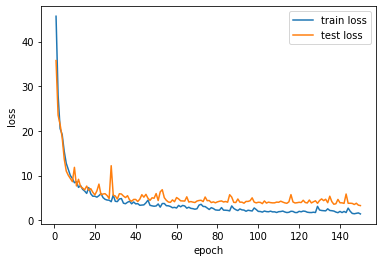

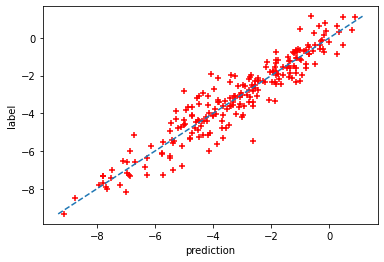

MSE: 122.38836792696125


In [61]:
from torch import optim
def main():
	wandb.init("GCN")
	device = 'cuda' if torch.cuda.is_available() else 'cpu'
	# load data and build the data loader
	train_set = get_dataset('/content/24789S22_hw4_code/q1_template/train_set.npy')
	test_set = get_dataset('/content/24789S22_hw4_code/q1_template/test_set.npy')
	train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
	test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

	# number of features in the dataset
	# no need to change the value
	n_features = 37

	# build your GNN model
	model = GraphNet(n_features)

	# define your loss and optimizer
	loss_func = nn.MSELoss()
	#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
	optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
	scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.5)

	print(model)

	hist = {"train_loss":[], "test_loss":[]}
	num_epoch = 150
	for epoch in range(1, 1+num_epoch):
		model.train()
		loss_all = 0
		for data in train_loader:
			# your codes for training the model
			# ...
			optimizer.zero_grad()
			output = model(data)
			label = data.y
			loss = loss_func(output.squeeze(), label)
			loss.backward()
			optimizer.step()
			loss_all += loss.item() * data.num_graphs * len(data)
		train_loss = loss_all / len(train_set)

		with torch.no_grad():
			loss_all = 0
			model.eval()
			for data in test_loader:
				# your codes for validation on test set
				preds = model(data)
				label = data.y
				loss = loss_func(preds.squeeze(), label)
				loss_all += loss.item() * data.num_graphs * len(data)
			test_loss = loss_all / len(test_set)
			model = model.train()
			hist["train_loss"].append(train_loss)
			hist["test_loss"].append(test_loss)
			wandb.log({"train loss": train_loss,
								"test_loss": test_loss,
								"epoch": epoch})
			print(f'Epoch: {epoch}, Train loss: {train_loss:.3}, Test loss: {test_loss:.3}')
		#scheduler.step()	
	# test on test set to get prediction 
	with torch.no_grad():
		model = model.eval()
		prediction = np.zeros(len(test_set))
		label = np.zeros(len(test_set))
		idx = 0
		for data in test_loader:
			data = data.to(device)
			output = model(data)
			prediction[idx:idx+len(output)] = output.squeeze().detach().numpy()
			label[idx:idx+len(output)] = data.y.detach().numpy()
			idx += len(output)
		prediction = np.array(prediction).squeeze()
		label = np.array(label).squeeze()
		model = model.train()

	# visualization
	# plot loss function
	ax = plt.subplot(1,1,1)
	ax.plot([e for e in range(1,1+num_epoch)], hist["train_loss"], label="train loss")
	ax.plot([e for e in range(1,1+num_epoch)], hist["test_loss"], label="test loss")
	plt.xlabel("epoch")
	plt.ylabel("loss")
	ax.legend()
	plt.show()

	# plot prediction vs. label
	x = np.linspace(np.min(label), np.max(label))
	y = np.linspace(np.min(label), np.max(label))
	ax = plt.subplot(1,1,1)
	ax.scatter(prediction, label, marker='+', c='red')
	ax.plot(x, y, '--')
	plt.xlabel("prediction")
	plt.ylabel("label")
	plt.show()
	print("MSE:", np.sum(np.square(prediction-label)))
	torch.save(model.state_dict(), "q1_model.pth")

if __name__ == "__main__":
	main()

In [62]:
()

()